# Box-Cox / Gnedin transformation for $n_\star$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from scipy import optimize

In [2]:
simple_igm=False
delta_lnprob_cut=50
if simple_igm:
    fname='chain_igm_1.npz'
else:
    fname='chain_igm_8.npz'

In [3]:
# true values for central simulation
true_x=0.34655
true_y=-2.297

In [4]:
data=np.load(fname)
x=data['Delta2_star']
y=data['n_star']
lnprob=data['lnprob']
# get rid of low-probability islands
max_lnprob=np.max(lnprob)
if delta_lnprob_cut:
    mask=(max_lnprob-lnprob<delta_lnprob_cut)
    print('will use {} / {} points'.format(np.sum(mask),len(lnprob)))
    x=x[mask]
    y=y[mask]
    lnprob=lnprob[mask]
prob=np.exp(lnprob-max_lnprob)

will use 448354 / 454400 points


In [5]:
def fit_gaussian(x):
    # compute ,moments
    mean=np.mean(x)
    rms=np.std(x)
    return mean,rms

In [6]:
def fit_robust_gaussian(x):
    # compute stats robust to outliers
    mean=np.median(x)
    rms=1.4826*stats.median_abs_deviation(x) 
    return mean,rms

In [7]:
def fit_boxcox(y,du=0.01,robust=True):
    if robust:
        # compute stats robust to outliers
        mean_y,rms_y=fit_robust_gaussian(y)
    else:
        mean_y,rms_y=fit_gaussian(y)
    # compute normalised residuals
    u=(y-mean_y)/rms_y
    min_u=np.min(u)
    u0=min_u-du
    # compute boxcox transform
    _,lam=stats.boxcox(u-u0)
    bc=((u-u0)**lam-1)/lam
    info={'mean_y':mean_y,'rms_y':rms_y,'u0':u0,'lam':lam}
    return bc,info

In [8]:
def gaussian(x,mean,rms):
    return np.exp(-0.5*((x-mean)/rms)**2)

In [9]:
def boxcox(y,info):
    u=(y-info['mean_y'])/info['rms_y']
    u0=info['u0']
    lam=info['lam']
    bc=((u-u0)**lam-1)/lam
    return bc

In [10]:
bc,info=fit_boxcox(y)
print(info)

{'mean_y': -2.3025672512599296, 'rms_y': 0.008097876724314461, 'u0': -5.130491140963575, 'lam': -0.08231908682216756}


In [11]:
true_bc=boxcox(true_y,info)

In [12]:
min_bc=min(bc)
max_bc=max(bc)
# compute (robust) mean and std
mean_bc,rms_bc=fit_robust_gaussian(bc)
# plotting 
plot_bc=np.linspace(min_bc,max_bc,500)

Text(0.5, 0, 'Box-Cox')

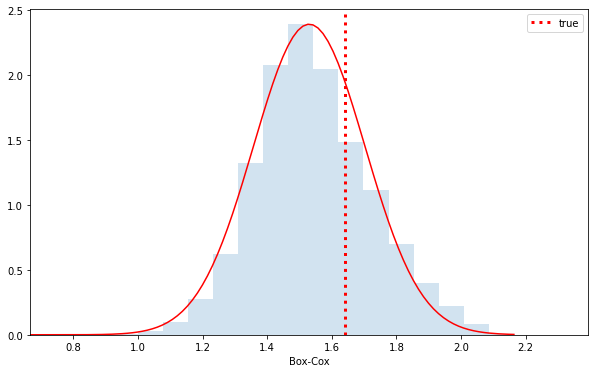

In [13]:
plt.figure(figsize=[10,6])
counts,bins,_=plt.hist(bc,bins=100,alpha=0.2,density=True)
plt.plot(plot_bc,np.max(counts)*gaussian(plot_bc,mean_bc,rms_bc),color='red')
plt.axvline(x=true_bc,ls=':',color='red',lw=3,label='true')
plt.xlim(mean_bc-5*rms_bc,mean_bc+5*rms_bc)
plt.legend()
plt.xlabel('Box-Cox')

## Fit 2D Gaussian for x-bc

In [14]:
def get_correlation(x,y):
    delta_lnprob_cut=20
    cut_lnprob=max_lnprob-delta_lnprob_cut
    mask=lnprob>cut_lnprob
    xx=x[mask]
    yy=y[mask]
    return np.corrcoef(xx,yy)

In [15]:
def fit_robust_gaussian_2d(x,y):
    # get correlation matrix using points only near the peak
    corr=get_correlation(x,y)
    # use more points to compute the median and MAD
    mean_x,rms_x=fit_robust_gaussian(x)
    mean_y,rms_y=fit_robust_gaussian(y)
    mean=np.array([mean_x,mean_y])
    # scale covariance with correlation matrix
    rms=np.array([rms_x,rms_y])
    cov=(rms*corr).transpose()*rms
    return mean, cov

In [16]:
def gauss_log_like(x,y,mean,invcov):
    diff=np.array([x-mean[0],y-mean[1]])
    return -0.5*np.dot(np.dot(invcov,diff),diff)

In [17]:
plot_bc=False
if plot_bc:
    yy=bc
    plot_fname='post_x_bc.png'
    ylabel='box-cox'
else:
    yy=y
    plot_fname='post_x_y.png'
    ylabel='n_star'
mean,cov=fit_robust_gaussian_2d(x,yy)
invcov=np.linalg.inv(cov)
rms=np.sqrt(cov.diagonal())
print(mean,cov)
# setup 2D grid
N=500
Nj=complex(0,N)
X, Y = np.mgrid[np.min(x):np.max(x):Nj, np.min(yy):np.max(yy):Nj]
# evaluate likelihood in 2D grid
log_like=np.array([gauss_log_like(x,y,mean,invcov) for (x,y) in zip(X.ravel(),Y.ravel())]).reshape(X.shape)
like=np.exp(log_like)

[ 0.349388   -2.30256725] [[1.78161007e-04 3.96269278e-05]
 [3.96269278e-05 6.55756074e-05]]


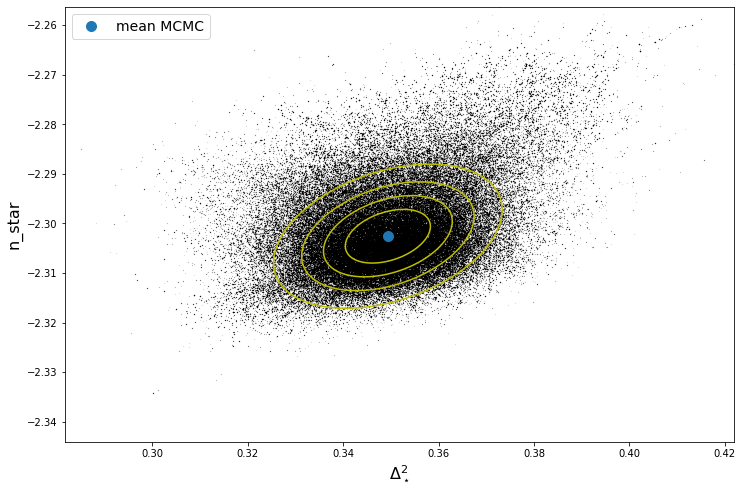

In [18]:
fig, ax = plt.subplots(1, 1,figsize=(12,8))
ax.plot(x, yy, 'k.', markersize=0.1)
#plt.imshow(np.rot90(like),cmap=plt.cm.gist_earth_r,extent=[np.min(x),np.max(x),np.min(y),np.max(y)])
ax.contour(X,Y,like,5,colors='y')
ax.plot(mean[0],mean[1],'o',markersize=10,label='mean MCMC')
#ax.plot(max_like_D2_star,max_like_n_star,'o',markersize=10,label='max like')
#ax.plot(true_D2_star,true_n_star,'o',markersize=10,label='true')
ax.legend(fontsize=14)
ax.set_xlabel(r'$\Delta^2_\star$',fontsize=16)
ax.set_ylabel(ylabel,fontsize=16);
plt.savefig(plot_fname)

# Redo for the transformation suggested by Nick Gnedin

In [19]:
def gnedin(u):
    us=u+0.2
    uf = us*(3.5-1.5*np.tanh(0.5*us))/3 - 0.03
    return uf

In [20]:
# compute residuals "u"
robust=True
if robust:
    # compute stats robust to outliers
    mean_y,rms_y=fit_robust_gaussian(y)
else:
    mean_y,rms_y=fit_gaussian(y)
print('n_star mean={:.6f}, rms={:.7f}'.format(mean_y,rms_y))
# compute normalised residuals
u=(y-mean_y)/rms_y
true_u=(true_y-mean_y)/rms_y

n_star mean=-2.302567, rms=0.0080979


In [21]:
g=gnedin(u)
true_g=gnedin(true_u)

In [22]:
min_g=min(g)
max_g=max(g)
# compute (robust) mean and std
mean_g,rms_g=fit_robust_gaussian(g)
# plotting 
plot_g=np.linspace(min_g,max_g,500)

Text(0.5, 0, 'Gnedin')

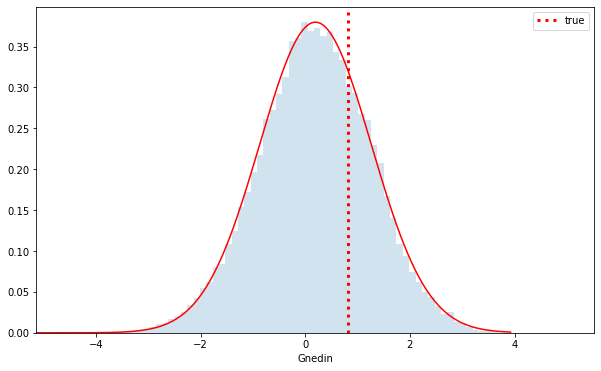

In [23]:
plt.figure(figsize=[10,6])
counts,bins,_=plt.hist(g,bins=100,alpha=0.2,density=True)
plt.plot(plot_g,np.max(counts)*gaussian(plot_g,mean_g,rms_g),color='red')
plt.axvline(x=true_g,ls=':',color='red',lw=3,label='true')
plt.xlim(mean_g-5*rms_g,mean_g+5*rms_g)
plt.legend()
plt.xlabel('Gnedin')

In [24]:
yy=g
plot_fname='post_x_g.png'
ylabel='Gnedin'
mean,cov=fit_robust_gaussian_2d(x,yy)
invcov=np.linalg.inv(cov)
rms=np.sqrt(cov.diagonal())
print(mean,cov)
# setup 2D grid
N=500
Nj=complex(0,N)
X, Y = np.mgrid[np.min(x):np.max(x):Nj, np.min(yy):np.max(yy):Nj]
# evaluate likelihood in 2D grid
log_like=np.array([gauss_log_like(x,y,mean,invcov) for (x,y) in zip(X.ravel(),Y.ravel())]).reshape(X.shape)
like=np.exp(log_like)

[0.349388   0.19336653] [[1.78161007e-04 5.05135409e-03]
 [5.05135409e-03 1.13831354e+00]]


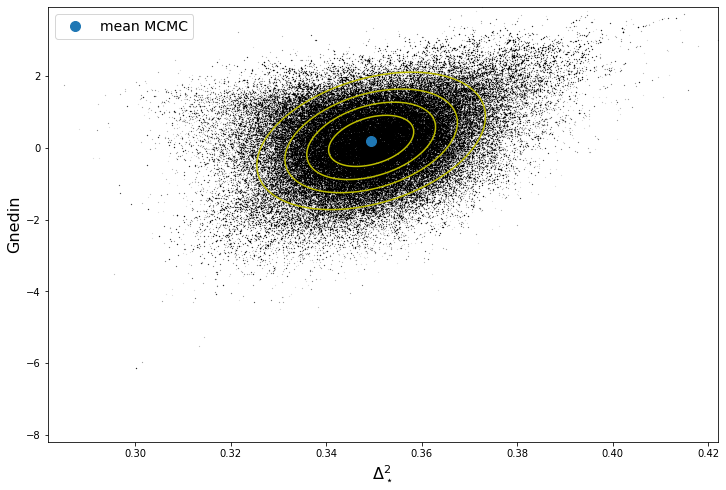

In [25]:
fig, ax = plt.subplots(1, 1,figsize=(12,8))
ax.plot(x, yy, 'k.', markersize=0.1)
#plt.imshow(np.rot90(like),cmap=plt.cm.gist_earth_r,extent=[np.min(x),np.max(x),np.min(y),np.max(y)])
ax.contour(X,Y,like,5,colors='y')
ax.plot(mean[0],mean[1],'o',markersize=10,label='mean MCMC')
#ax.plot(max_like_D2_star,max_like_n_star,'o',markersize=10,label='max like')
#ax.plot(true_D2_star,true_n_star,'o',markersize=10,label='true')
ax.legend(fontsize=14)
ax.set_xlabel(r'$\Delta^2_\star$',fontsize=16)
ax.set_ylabel(ylabel,fontsize=16);
plt.savefig(plot_fname)